In [5]:
import pandas as pd
import os
import numpy as np
import re
import sys
from matplotlib import pyplot as plt
import time
from collections import defaultdict

from gensim.models import Word2Vec

In [193]:
def _plot_word22d(p, model):
    
    words = model.wv.index2word
    pts = np.array([model.wv[word] for word in words])
    T_pts = pts.T

    p.scatter(T_pts[0], T_pts[1])
    for i, word in enumerate(words):
        p.annotate(word, pts[i])
        
    origin = [0, 0]
    p.scatter(origin[0], origin[1], s=100)
    p.annotate("ORIGIN", origin, fontsize=14)
    
    mean_pt = pts.mean(axis=0)
    p.scatter(mean_pt[0], mean_pt[1], s=100)
    p.annotate("MEAN", mean_pt, fontsize=14)
    
    if "_" in words:
        kernel = model.wv["_"]
        p.scatter(kernel[0], kernel[1], c="red", s=100)
        p.annotate("UNDERSCORE", kernel, fontsize=14)
        
    if "UNKNOWN" in words:
        unknown = model.wv["UNKNOWN"]
        p.scatter(unknown[0], unknown[1], c="pink", s=100)
        p.annotate("UNKNOWN", unknown, fontsize=14)
        
        
def report_underscore(model1, model2):

    plt.figure(figsize=[12, 6])

    p1 = plt.axes([0, 0, 0.48, 0.96])
    _plot_word22d(p1, model1)

    p2 = plt.axes([0.54, 0, 0.48, 0.96])
    _plot_word22d(p2, model2)

    p3 = plt.axes([0, 0.98, 1, 0.04])
    
    word_n = len(model2.wv.index2word)
    title = "Number of words: %d"%word_n
    p3.text(0.4, 0, title, fontsize=20)
    p3.set_axis_off()
    
    plt.show()

In [210]:
def load_data_df(path):
    df = pd.read_csv(path,
                     encoding="ISO8859",
                     index_col=0)
    return df


def preprocess(df):
    
    def process(i, text):
        text = re.sub("<br />", " ", text)
        text = re.sub("[^A-Za-z0-9 .\-']", "", text)
        text = re.sub("\d+", "00", text)
        text = re.sub("-", " ", text)
        text = re.sub("\.", " ", text)
        text = re.sub("\s+", " ", text)
        if i%100 == 0:
            percent = i/data_n*100
            sys.stdout.write("\r% 5.2f%%"%(percent))
        return text.lower()
    
    data_n = len(df)
    review_se = df["review"]
    
    print("[load_data_df] Preprocessing data...")
    review_se = pd.Series(
        [process(i, review)
         for i, review in enumerate(review_se)]
    )
    sys.stdout.write("\r% 5.2f%%\n"%(100))
    
    df["review"] = review_se
    return df


def get_freq(df):

    data_n = len(df)
    review_se = df["review"]
    freq=defaultdict(int)

    print("[load_data_df] Calculating word frequency...")
    for i, words in enumerate(review_se):
        for word in words:
            freq[word] += 1
        if i%100 == 0:
            percent = i/data_n*100
            sys.stdout.write("\r% 5.2f%%"%(percent))
    sys.stdout.write("\r% 5.2f%%\n"%(100))
    
    return freq


def get_normal8underscore_df(df):
    
    df = df[df["label"] != "unsup"]
    review_se = df["review"]
    
    underscore_df = df.copy()
    df = df.copy()
    
    underscore_df["review"] = [
        "_ "+" ".join((" _ ".join(sent.split()).split()))+" _"
        for sent in review_se
    ]
    
    df["review"] = [sent.split() for sent in df["review"]]
    underscore_df["review"] = [
        sent.split() for sent in underscore_df["review"]
    ]

    return df, underscore_df


def set_unknown(df, freq, min_count):
    
    def check8convert(i, words):
        text_list = [
            "UNKNOWN" if freq[word] < min_count else word
             for word in words
        ]
        return text_list
    
    df = df.copy()
    data_n = len(df)
    review_se = df["review"]
    
    review_se = pd.Series([check8convert(i, words) for i, words
                           in enumerate(review_se)])                
    df["review"] = review_se
    
    return df

[load_data_df] Preprocessing data...
 100.00%
[load_data_df] Calculating word frequency...
 100.00%


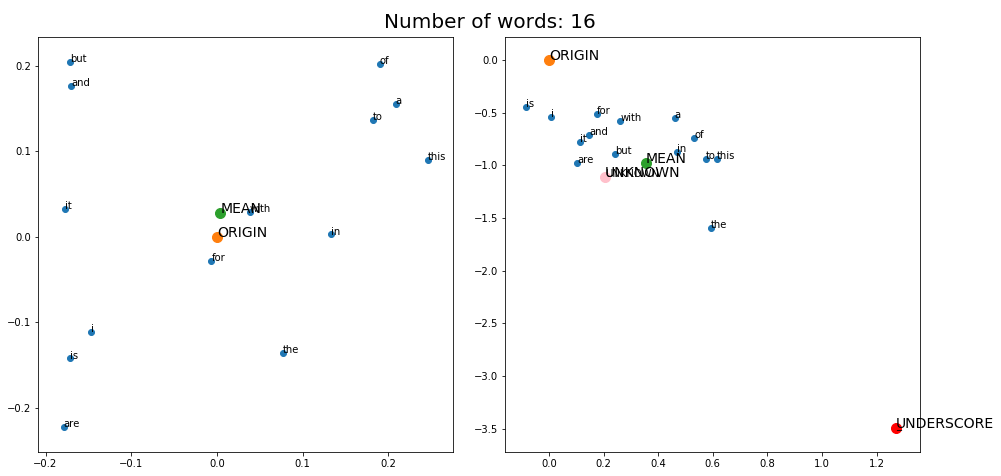

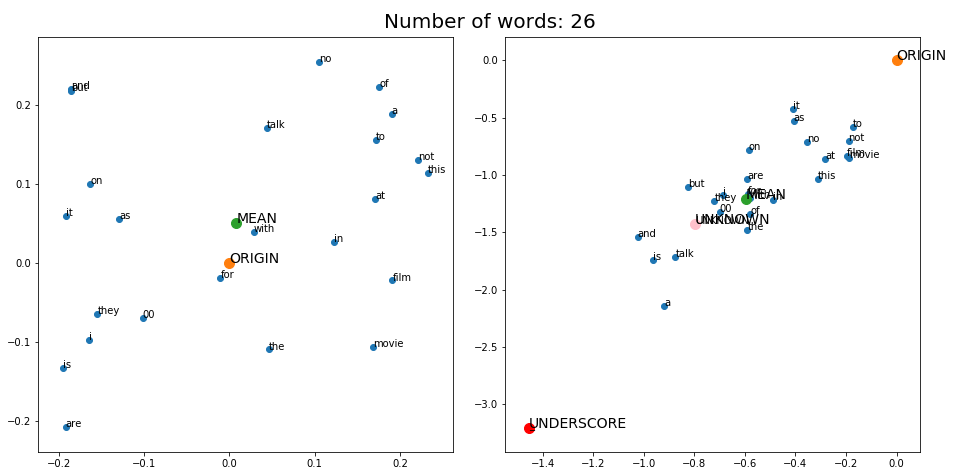

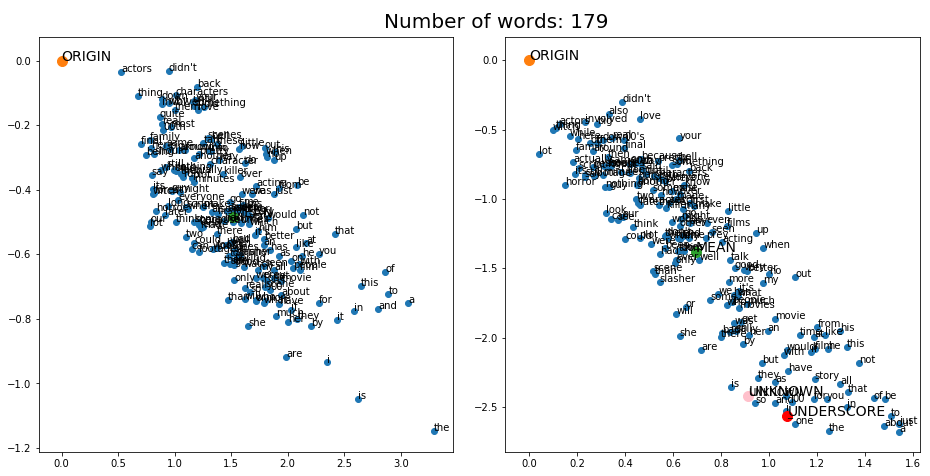

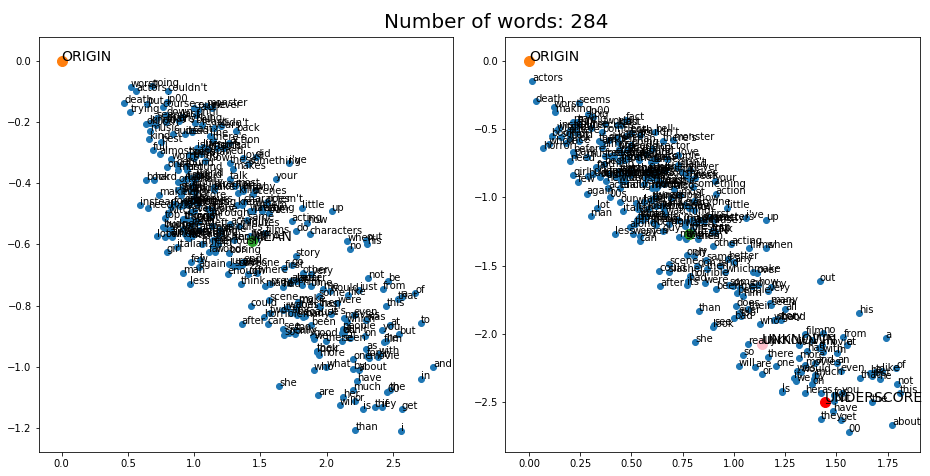

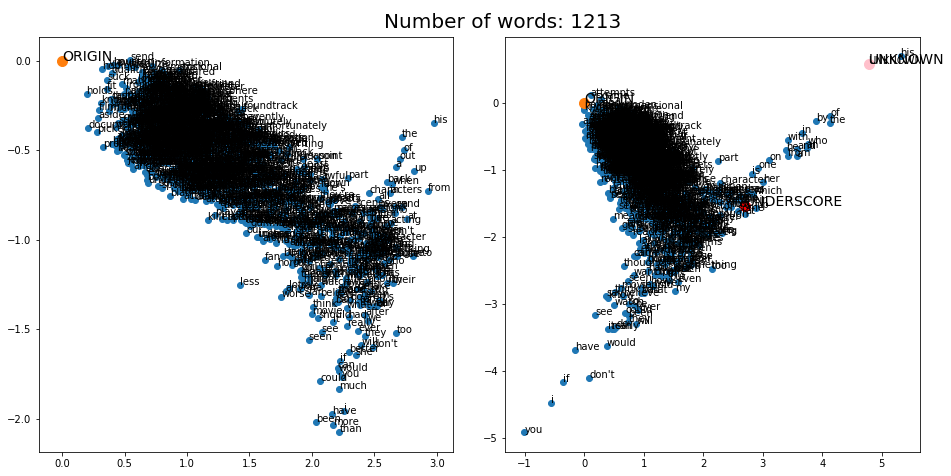

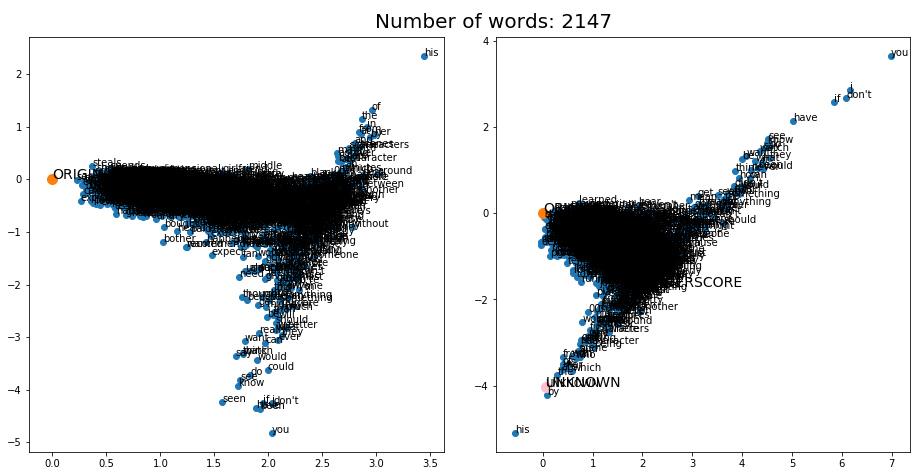

In [216]:
case_index = 0
case = ["report", "embedding"][case_index]

min_count = 10
normal_window = 5
underscore_window = normal_window*2
workers = os.cpu_count()

df = load_data_df("./data/master.csv")
df = preprocess(df)
normal_df, underscore_df = get_normal8underscore_df(df)

freq = get_freq(underscore_df)
unknown_df = set_unknown(underscore_df, freq, min_count)

if case == "report":
    size = 2
    data_ns = [5, 10, 50, 100, 500, 1000]
elif case == "embedding":
    size = 128
    data_ns = [len(normal_df)]

    
for data_n in data_ns:    

    model1 = Word2Vec(normal_df["review"][:data_n],
                      size=size,
                      window=normal_window,
                      min_count=min_count,
                      workers=workers)

    model2 = Word2Vec(unknown_df["review"][:data_n],
                      size=size,
                      window=underscore_window,
                      min_count=min_count,
                      workers=workers)
    
    if case == "report":
        report_underscore(model1, model2)
    elif case == "embedding":
        model1.save("./data/normal_model")
        model2.save("./data/underscore_model")